# Yearly mean CO2 emissions factors of electricity generation

In this script we calculated a yearly mean CO2 emissions factor of electricity generation per country for past years. The applied method is based on a published procedures from the European Enviroment Agency (EEA).

EEA methode documentation: https://www.eea.europa.eu/data-and-maps/data/co2-intensity-of-electricity-generation/


# Script setup

In [1]:
import os
import logging

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from IPython.display import Image 

%matplotlib inline
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [15, 10]

#helpers
def get_country(string):
    # split string and takes the first part
    string = string.split(',')[-1]
    return string

def aligndata(data, CO2_cleaned):
    #consider only countries which appear in both datasets; to have all of them included specific effort is needed.
    data = data[pd.Series(CO2_cleaned.columns)[pd.Series(CO2_cleaned.columns).apply(lambda x: x in data.columns)]].sort_index()
    data = data.set_index(CO2_cleaned.index)
    return data

# Data directory preparention

In [2]:
# Create input, processed and output folders if they don't exist
# If the paths are relative, the correspoding folders will be created inside the current working directory.

input_directory_path = os.path.join('input')
EEA_methode_input_directory_path = os.path.join('input', 'EEA_Methode')
processed_directory_path = 'processed'
output_directory_path = os.path.join('output')

os.makedirs(input_directory_path, exist_ok=True)
os.makedirs(EEA_methode_input_directory_path, exist_ok=True)
os.makedirs(processed_directory_path, exist_ok=True)
os.makedirs(output_directory_path, exist_ok=True)

# Data file preperation

The directory `input/EEA_Methode` should contain all necessary raw data files.

Based on the EEA methode two data sets needed:

1) Eurostat energy balance database
https://ec.europa.eu/eurostat/web/energy/data/database
Complete energy balances as ZIP archive -> nrg_bal_c.tsv (tab separated file)
https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?file=data/nrg_bal_c.tsv.gz

2) National emissions reported to the UNFCCC and to the EU Greenhouse Gas Monitoring Mechanism
https://www.eea.europa.eu/data-and-maps/data/national-emissions-reported-to-the-unfccc-and-to-the-eu-greenhouse-gas-monitoring-mechanism-16
Reported emissions as ZIP archive -> UNFCCC_v23.csv (ASCII delimited)
https://www.eea.europa.eu/data-and-maps/data/national-emissions-reported-to-the-unfccc-and-to-the-eu-greenhouse-gas-monitoring-mechanism-16/national-greenhouse-gas-inventories-ipcc-common-reporting-format-sector-classification/ascii-delimited-zip-2/at_download/file



In [3]:
# Checks if the the input directories are empty or not
# Checks all filenames in the input directory

if not os.listdir(EEA_methode_input_directory_path) :
    print("The directory for the EEA methode is empty. Please provide the data to the directory as described in the instructions above.")


EEA_filenames = [os.path.join(EEA_methode_input_directory_path, fn) for fn in os.listdir(EEA_methode_input_directory_path)]

print(EEA_filenames)

['input\\EEA_Methode\\EEA_methodology.png', 'input\\EEA_Methode\\nrg_bal_c.csv', 'input\\EEA_Methode\\UNFCCC_v23.csv']


# Load data functions

In [4]:
def load_energy_balance_data(path, fn):
    """
    Load the raw energy balances reported in the eurostat database for all european countriesenergy from input directory.
        
    Parameters
    ----------
    path: str
        path to data
    fn : str
        filename
        
    """
    
    logging.info(f'Loading data from {fn}')
    
    df = pd.read_csv(os.path.join(path, fn),sep = '\t', header=0)
    # rename column (0) for identifier
    df = df.rename(columns = {df.columns[0]:'use_substance_unit_country'})

    return df


def load_UNFCC_data(path, fn):
    """
    Load and standardize the raw UNFCC database for all european countriesenergy from input directory.
    Filter data: only sector '1.A.1.a' (CO2 for all energy production from Public Electricity Generation, Public Combined Heat and Power and Public Heat Plants)
    Filter data: only direct CO2 emissions
    Filter data: only from year 1990 upwards
    CO2 emmissions in million tones Tg

    Parameters
    ----------
    path: str
        path to data
    fn : str
        filename

    """
    

    logging.info(f'Loading data from {fn}')
    
    df = pd.read_csv(os.path.join(path, fn), sep = ',', header =0, encoding = 'unicode_escape',low_memory=False)
    
    #sector and polutant selection
    sector = '1.A.1.a' # CO2 for all energy production from Public Electricity Generation, Public Combined Heat and Power and Public Heat Plants
    pollutant = 'CO2' # only direct CO2
    
    df = df.query('Sector_code == @sector').query('Pollutant_name == @pollutant')
    
    # data only from year 1990 upwards 
    df = df[~df['Year'].isin(['1985-1987'])] # skip an entry with several years
    # convert all years to string
    df['Year']= df['Year'].apply(lambda x: int(x)).apply(lambda x: str(x))
    
    df = df[~df['Year'].isin(['1985','1986','1987','1988','1989'])] # filter for years
    
    # Create table with countries as columns and years as rows 
    df = pd.pivot_table(df, values = 'emissions', index = 'Year', columns = ['Country_code'])

    return df

# Methodology

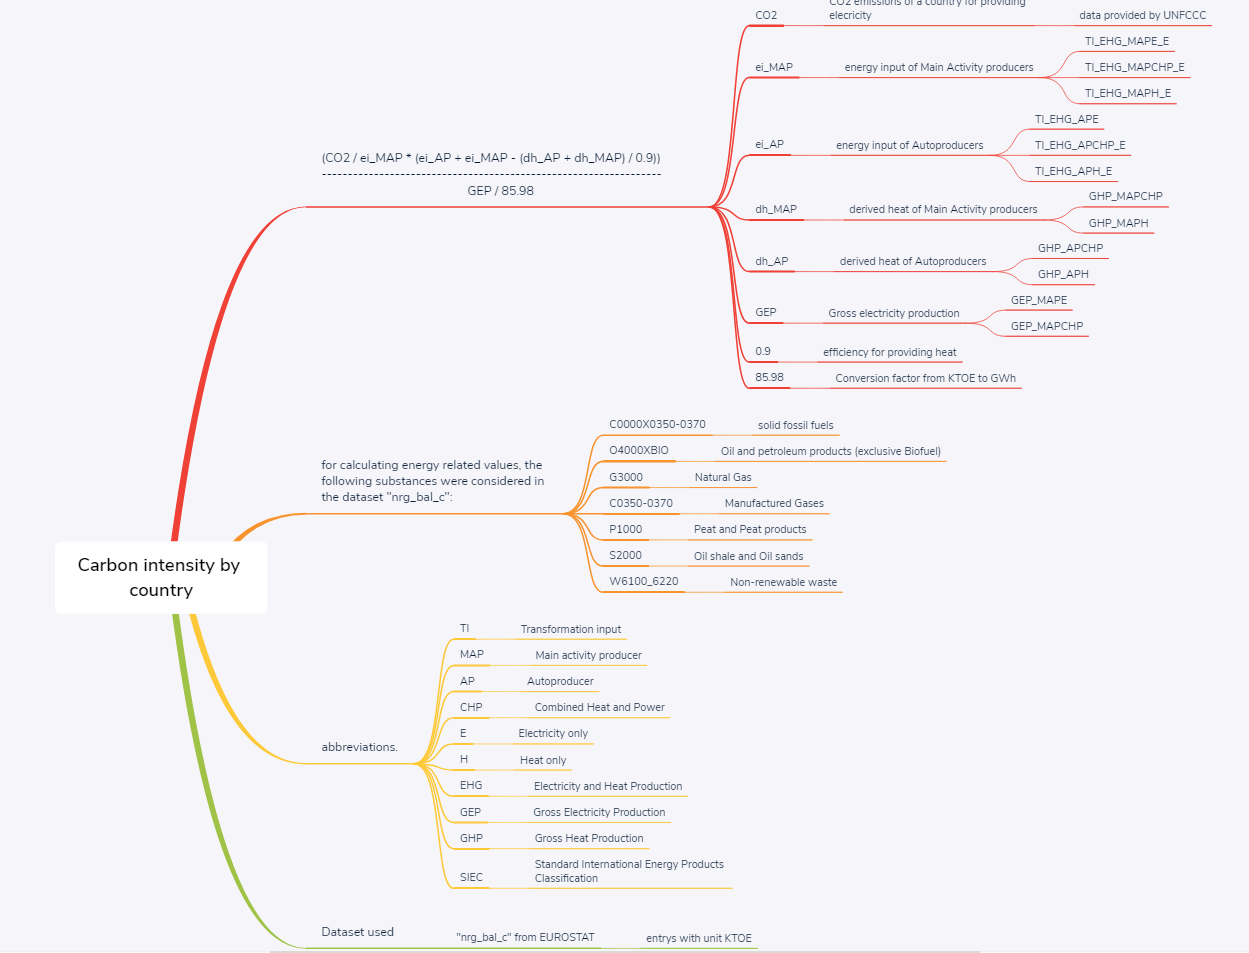

In [5]:
# The following image give information about the used data sets, abbrevations and calculation mathode
Image(filename="Input/EEA_Methode/EEA_methodology.png")

## load CO2_emissions reported from UNFCC

In [6]:
CO2_emissions_UNFCC = load_UNFCC_data(EEA_methode_input_directory_path, 'UNFCCC_v23.csv')
# attention public electricity and heat generation only no autoproducers

## load energy balance sheet reported from eurostat

In [7]:
nrg_bal_c = load_energy_balance_data(EEA_methode_input_directory_path, 'nrg_bal_c.csv')

## energy related calculations

caculation for ei_MAP, ei_AP, dh_MAP, dh_AP, GEP
see image for further information

In [21]:
#using only substances provided in the example excel-sheet (Austria Example). Nevertheless, the methodology on the website
#suggests using two more substances namely primary biogases and primary solid biofuels

# Solid fossil fuel; C0000X0350-0370;
# Oil and petroleum products (excl. Biofuel); O4000XBIO;
# Natural Gas; G3000;
# Manufactured gases; C0350-0370;
# Peat and peat products; P1000;
# Oil shale and Oil sands; S2000;
#--- not in the example but in the documentation Primary solid biofuels; R5110-5150_W6000RI;
#--- not in the example but in the documentation Primary Biogases; R5300;
# Non-renewable waste; W6100_6220.

# set filter substance

substances = 'C0000X0350-0370|O4000XBIO|G3000|C0350-0370|P1000|S2000|W6100_6220'

In [9]:
#energy input of main activity producers (ei_MAP)
#Transformation input Electricity & heat generation

#Main activity producer electricity only; TI_EHG_MAPE_E
#Main activity producer CHP; TI_EHG_MAPCHP_E
#Main activity producer heat only; TI_EHG_MAPH_E
ei_MAP_string_nrgbalc = 'TI_EHG_MAPE_E|TI_EHG_MAPCHP_E|TI_EHG_MAPH_E'


#filter with ei_MAP_string_nrgbalc and substances
ei_MAP = nrg_bal_c.loc[nrg_bal_c['use_substance_unit_country']\
                                    .str.contains(ei_MAP_string_nrgbalc, regex=True)]
ei_MAP = ei_MAP.loc[ei_MAP['use_substance_unit_country']\
                                     .str.contains(substances, regex=True)]
ei_MAP = ei_MAP.loc[ei_MAP['use_substance_unit_country']\
                                    .str.contains(r'^(?=.*KTOE)')]
# split country from identifier
ei_MAP.use_substance_unit_country = ei_MAP.use_substance_unit_country.apply(lambda string: get_country(string))
# rename columns and set index
ei_MAP = ei_MAP.rename(columns = {'use_substance_unit_country':'Country_code'})\
           .set_index('Country_code')\
           .replace(': ',0.)\
           .replace(': z',0.)\
           .apply(lambda x: x.apply(lambda y:float(y)))\
           .groupby(by=ei_MAP.index.name,level = 0).sum()\
           .T

In [10]:
#calculating the energy input of Autoproducters (ei_AP)
#Transformation input Electricity & heat generation

#Autoproducer electricity only; TI_EHG_APE_E
#Autoproducer producer CHP; TI_EHG_APCHP_E
#Autoproducer producer heat only; TI_EHG_APH_E

AP_string = 'TI_EHG_APE_E|TI_EHG_APCHP_E|TI_EHG_APH_E'
ei_AP = nrg_bal_c.loc[nrg_bal_c['use_substance_unit_country'].str.contains(AP_string, regex=True)]

ei_AP = ei_AP.loc[ei_AP['use_substance_unit_country']\
                                                    .str.contains(substances,regex=True)]#
ei_AP = ei_AP.loc[ei_AP['use_substance_unit_country']\
                                      .str.contains(r'^(?=.*KTOE)')]
ei_AP.use_substance_unit_country = ei_AP.use_substance_unit_country\
                                                    .apply(lambda string: get_country(string))
ei_AP = ei_AP.rename(columns = {'use_substance_unit_country':'Country_code'})\
           .set_index('Country_code')\
           .replace(': ',0.)\
           .replace(': z',0.)\
           .apply(lambda x: x.apply(lambda y:float(y)))\
           .groupby(by=ei_AP.index.name,level = 0).sum()\
            .T


In [11]:
#calculating the derived heat of main activity producers(dh_MAP)
#Gross heat production

#Main activity producer CHP; GHP_MAPCHP
#Main activity producer heat only; GHP_MAPH

#filter
derived_heat_string_nrgbalc = 'GHP_MAPCHP|GHP_MAPH'

dh_MAP = nrg_bal_c.loc[nrg_bal_c['use_substance_unit_country']\
                                     .str.contains(derived_heat_string_nrgbalc, regex=True)]
dh_MAP = dh_MAP.loc[dh_MAP['use_substance_unit_country']\
                                        .str.contains(substances, regex=True)]
dh_MAP = dh_MAP.loc[dh_MAP['use_substance_unit_country']\
                                      .str.contains(r'^(?=.*KTOE)')]
dh_MAP.use_substance_unit_country = dh_MAP.use_substance_unit_country\
                                     .apply(lambda string: get_country(string))
dh_MAP = dh_MAP.rename(columns = {'use_substance_unit_country':'Country_code'})\
           .set_index('Country_code')\
           .replace(': ',0.)\
           .replace(': z',0.)\
           .apply(lambda x: x.apply(lambda y:float(y)))\
           .groupby(by=dh_MAP.index.name,level = 0).sum()\
           .T\
           #/ 0.9 # Estimating 90% efficiency heat production

In [12]:
#calculating the derived heat of Autoproducters (dh_AP)
#Gross heat production

#Autoproducer CHP; GHP_APCHP
#Autoproducer heat only; GHP_APH

dh_AP_string = 'GHP_APCHP|GHP_APH'
dh_AP = nrg_bal_c.loc[nrg_bal_c['use_substance_unit_country']\
                                     .str.contains(dh_AP_string, regex=True)]
dh_AP = dh_AP.loc[dh_AP['use_substance_unit_country']\
                                        .str.contains(substances, regex=True)]
dh_AP = dh_AP.loc[dh_AP['use_substance_unit_country']\
                                      .str.contains(r'^(?=.*KTOE)')]
dh_AP.use_substance_unit_country = dh_AP.use_substance_unit_country\
                                     .apply(lambda string: get_country(string))
dh_AP = dh_AP.rename(columns = {'use_substance_unit_country':'Country_code'})\
           .set_index('Country_code')\
           .replace(': ',0.)\
           .replace(': z',0.)\
           .apply(lambda x: x.apply(lambda y:float(y)))\
           .groupby(by=dh_AP.index.name,level = 0).sum()\
           .T\
           #/ 0.9 # Estimating 90% efficiency heat production


In [13]:
#caclulating gross electricty prodcution of main activity producers (GEP)
#Gross electricity production

#Main activity producer electricity only; GEP_MAPE
#Main activity producer CHP; GEP_MAPCHP

MAP_string = 'GEP_MAPE|GEP_MAPCHP'

GEP_MAP = nrg_bal_c.loc[nrg_bal_c['use_substance_unit_country'].str.contains(MAP_string, regex=True)]

GEP_MAP = GEP_MAP.loc[GEP_MAP['use_substance_unit_country']\
                                                      .str.contains(r'^(?=.*KTOE)(?=.*TOTAL)')]
GEP_MAP.use_substance_unit_country = GEP_MAP.use_substance_unit_country\
                                                      .apply(lambda string: get_country(string))
GEP_MAP = GEP_MAP.rename(columns = {'use_substance_unit_country':'Country_code'})\
           .set_index('Country_code')\
           .replace(': ',0.)\
           .replace(': z',0.)\
           .apply(lambda x: x.apply(lambda y:float(y)))\
           .groupby(by=GEP_MAP.index.name,level = 0).sum()\
           .T


In [14]:
#aclulating gross electricty prodcution of Autoproductersof (GEP_AP)

#Gross electricity production

#Autoproducer electricity only; GEP_APE
#Autoproducer CHP; GEP_APCHP

AP_string = 'GEP_APE|GEP_APCHP'

GEP_AP = nrg_bal_c.loc[nrg_bal_c['use_substance_unit_country'].str.contains(AP_string, regex=True)]

GEP_AP = GEP_AP.loc[GEP_AP['use_substance_unit_country']\
                                                    .str.contains(r'^(?=.*KTOE)(?=.*TOTAL)')]
GEP_AP.use_substance_unit_country = GEP_AP.use_substance_unit_country\
                                                    .apply(lambda string: get_country(string))
GEP_AP = GEP_AP.rename(columns = {'use_substance_unit_country':'Country_code'})\
           .set_index('Country_code')\
           .replace(': ',0.)\
           .replace(': z',0.)\
           .apply(lambda x: x.apply(lambda y:float(y)))\
           .groupby(by=GEP_AP.index.name,level = 0).sum()\
           .T


# Main Methode

In [15]:
#filter CO2_emissions_UNFCC using only columns that exist in both dataframes
CO2_cleaned = CO2_emissions_UNFCC[pd.Series(CO2_emissions_UNFCC.columns)[pd.Series(CO2_emissions_UNFCC.columns).apply(lambda x: x in ei_MAP.columns)]]

In [16]:
# fit data to CO2_cleaned data columns and rows

#Transformation input Main activity producer electricity only, CHP and heat
ei_MAP = aligndata(ei_MAP,CO2_cleaned)

#Gross heat production Main activity producer CHP and heat
dh_MAP= aligndata(dh_MAP, CO2_cleaned)

#Transformation input Autoproducer electricity only, CHP and heat
ei_AP = aligndata(ei_AP, CO2_cleaned)

#Gross heat production Autoproducer CHP and heat
dh_AP = aligndata(dh_AP, CO2_cleaned)

#electricity production Main activity producer
GEP_MAP= aligndata(GEP_MAP, CO2_cleaned) 

#electricity production Autoproducer
GEP_AP = aligndata(GEP_AP, CO2_cleaned)

#Gross electricity production
GEP = GEP_AP + GEP_MAP



In [17]:
# CO2 intensity of total electricity generation
# Is calculated by the ratio of all CO2 emissions from all electricity production (public main activity producers and autoproducers)
# against total electricity generation including all sources.

# Main activity producer

# First, the CO2 emissions of gross electricity production:
# total CO2 emissions multiplying by
# electricity production (plus energy losses) from public conventional thermal power stations
# versus all electrical energy production from public power stations and combined heat power station

# CO2 emissions * ((electrical energy + energy losses)/(electrical energy + derived heat + energy losses))

# 1) assumption
# (electrical energy + energy losses) = (electrical energy + derived heat + energy losses)–(derived heat)

# (electrical energy + derived heat + energy losses) = ei_MAP
 
# 2) assumption
# energy input calculation for derived heat with eff. of 0.9
# (derived heat) = (dh_MAP / 0.9)

# resulting in:
# energy input electrical energy production
# (electrical energy + derived heat + energy losses)–(derived heat) = ei_MAP - (dh_MAP / 0.9)
ei_elec_MAP = ei_MAP - (dh_MAP / 0.9)

# ((electrical energy + energy losses)/(electrical energy + derived heat + energy losses)) = ((ei_MAP - (dh_MAP / 0.9)) / ei_MAP) 

# share of CO2 emissions of electricity production Main activity producer
CO2_from_MAP_elec = CO2_cleaned * (ei_elec_MAP / ei_MAP) 


# Autoproducer

# The reported CO2 emissions in class 1A1a do not include CO2 emissions from autoproducers.
# Emissions from autoproducers were therefore estimated

# electricity output of autoproducers (same assumption as above)
ei_elec_AP = (ei_AP - (dh_AP / 0.9)) 

# 1) assumption
# this was done by multiplying the electricity output of autoproducers 
# by a calculated CO2 emission ratio for main activity producers


# share of CO2 emissions of electricity production Autoproducer
CO2_from_AP_elec = CO2_from_MAP_elec * (ei_elec_AP / ei_elec_MAP)


# CO2 intensity of total electricity generation

# sum of CO2 from MAP and CO2 from AP [CO2 in Gigagramm (Gg)] / Gross electricity production [GWh](85.98: Ktoe-->GWh)

CI_calc = ((CO2_from_MAP_elec + CO2_from_AP_elec)/(GEP/85.98)) # CO2 intensity in [g CO2/kWh]

In [18]:
CI_calc.index

Index(['1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998',
       '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007',
       '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017', '2018'],
      dtype='object', name='Year')

Text(0, 0.5, 'CO2 intensity [g CO2/kWh]')

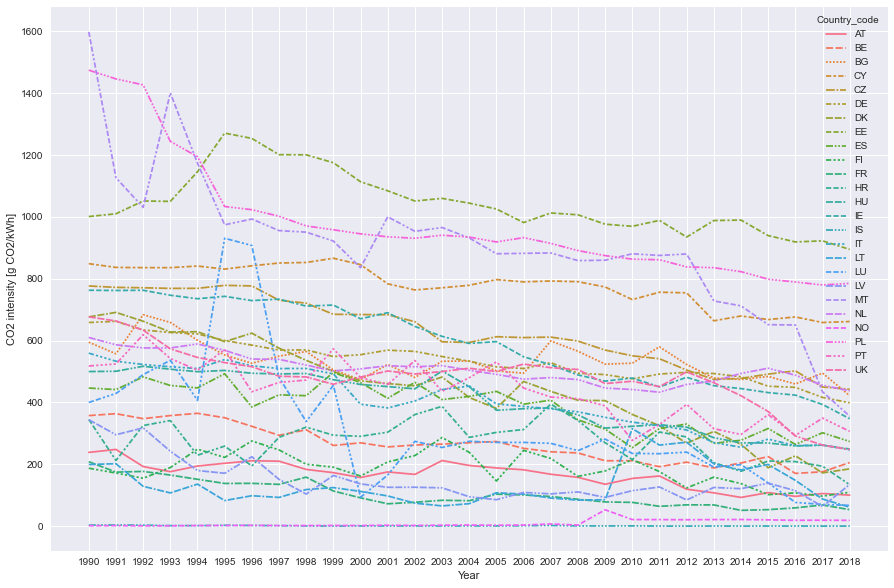

In [19]:
plt.figure()

ax = sns.lineplot(data=CI_calc)

ax.set_ylabel("CO2 intensity [g CO2/kWh]")

In [20]:
CI_calc.to_csv(output_directory_path + '/CI_EEA_recalculated.csv')